 If you are using it in colab then make a folder in the content folder in colab, then copy the path and paste to where you see [paste the path here].

# **Deblur_GAN**

In [1]:
!git clone https://github.com/VITA-Group/DeblurGANv2

Cloning into 'DeblurGANv2'...
remote: Enumerating objects: 902, done.
remote: Counting objects: 100% (274/274), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 902 (delta 151), reused 149 (delta 149), pack-reused 628 (from 1)
Receiving objects: 100% (902/902), 66.04 MiB | 9.29 MiB/s, done.
Resolving deltas: 100% (479/479), done.


In [2]:
!cd  ./DeblurGANv2

In [3]:
!cd DeblurGANv2/

In [4]:
import os

# Function to Get the current
# working directory
def current_path():
    print("Current working directory before")
    print(os.getcwd())
    print()


# Driver's code
# Printing CWD before
current_path()

# Changing the CWD
os.chdir('./DeblurGANv2')

# Printing CWD after
current_path()

Current working directory before
/content

Current working directory before
/content/DeblurGANv2



In [ ]:
!ls

Put the image file path in the (filename='')

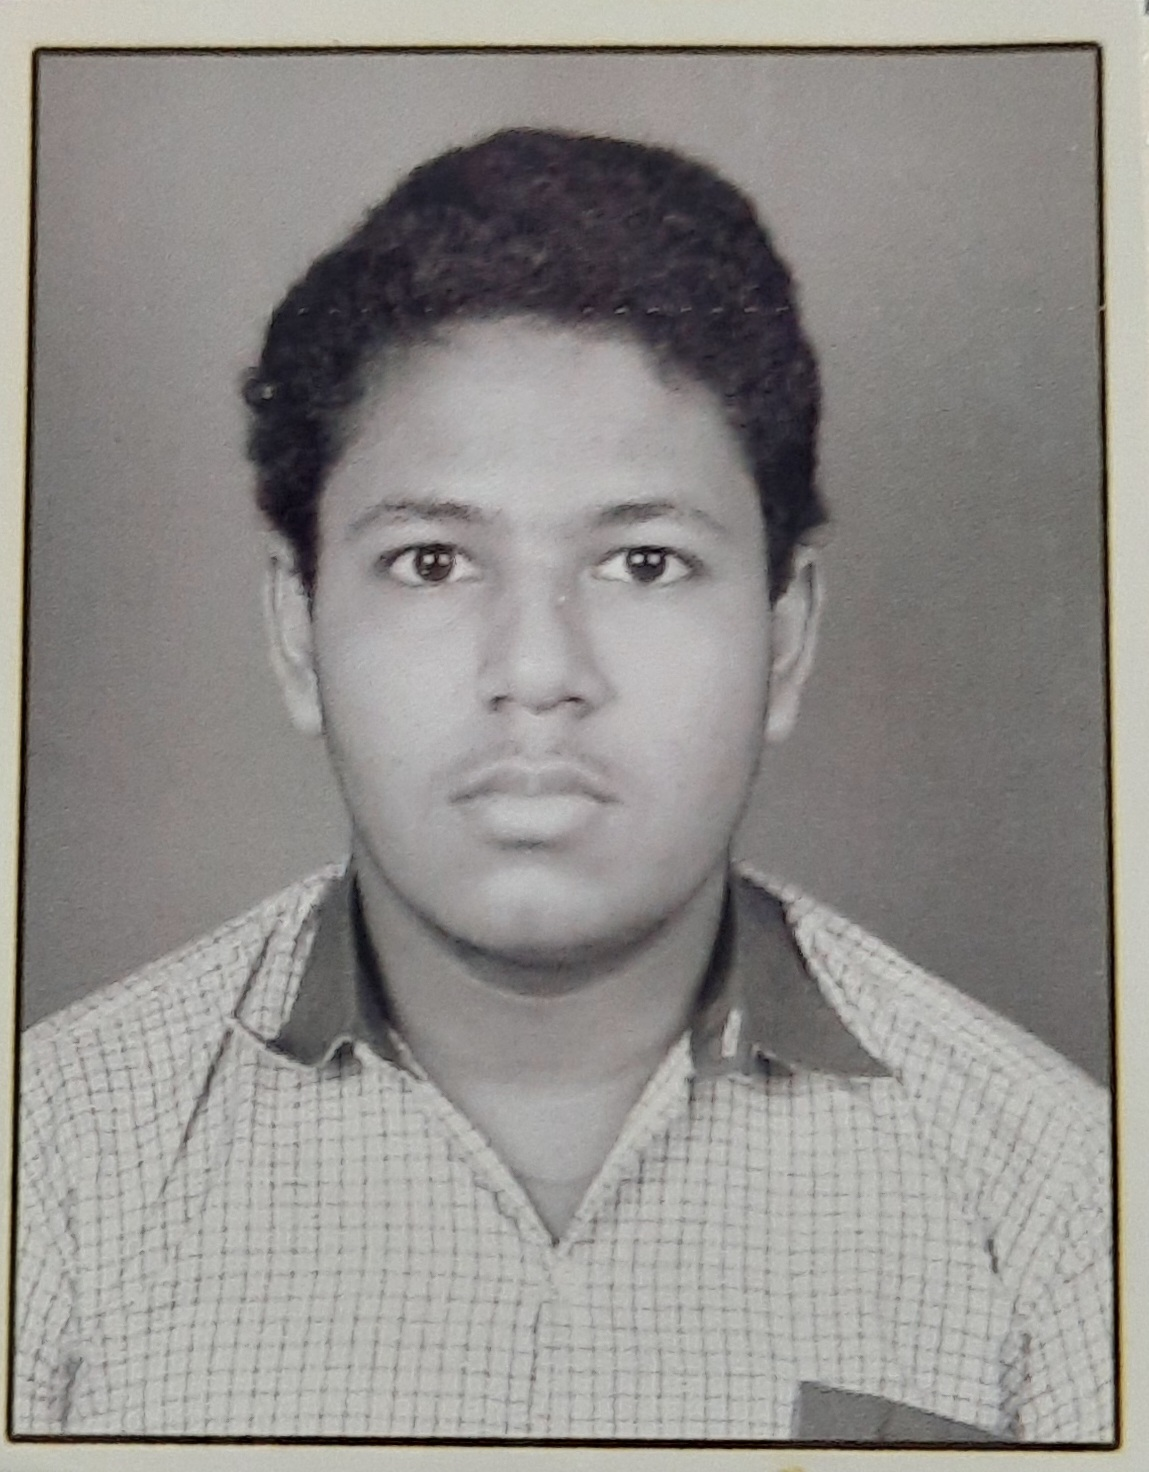

In [5]:
from IPython.display import Image
Image(filename='/content/20221104_175324.jpg') #location of image file or image

In [6]:
!wget -O fpn_inception.h5 'https://docs.google.com/uc?export=download&id=1UXcsRVW-6KF23_TNzxw-xC0SzaMfXOaR&confirm=t' #https://drive.google.com/open?id=1UXcsRVW-6KF23_TNzxw-xC0SzaMfXOaR&authuser=0

--2024-09-26 20:26:21--  https://docs.google.com/uc?export=download&id=1UXcsRVW-6KF23_TNzxw-xC0SzaMfXOaR&confirm=t
Resolving docs.google.com (docs.google.com)... 142.251.10.113, 142.251.10.100, 142.251.10.101, ...
Connecting to docs.google.com (docs.google.com)|142.251.10.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1UXcsRVW-6KF23_TNzxw-xC0SzaMfXOaR&export=download [following]
--2024-09-26 20:26:23--  https://drive.usercontent.google.com/download?id=1UXcsRVW-6KF23_TNzxw-xC0SzaMfXOaR&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.4.132, 2404:6800:4003:c06::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.4.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2428 (2.4K) [text/html]
Saving to: ‘fpn_inception.h5’

fpn_inception.h5    100%[===================>]   2.37K  --.-KB/s    in 0s    

Put the image in the place of [20221104_175324.jpg]

In [7]:
!ls submit/

000001.png  000019.png	000201.png


**Main function**

In [8]:
%%writefile predict1.py
​
import os
from glob import glob
from typing import Optional
​
import cv2
import numpy as np
import torch
import yaml
from fire import Fire
from tqdm import tqdm
​
from aug import get_normalize
from models.networks import get_generator
​
​
class Predictor:
    def __init__(self, weights_path: str, model_name: str = ''):
        with open('config/config.yaml',encoding='utf-8') as cfg:
            config = yaml.load(cfg, Loader=yaml.FullLoader)
        model = get_generator(model_name or config['model'])
        model.load_state_dict(torch.load(weights_path)['model'])
        self.model = model.cuda()
        self.model.train(True)
        # GAN inference should be in train mode to use actual stats in norm layers,
        # it's not a bug
        self.normalize_fn = get_normalize()
​
    @staticmethod
    def _array_to_batch(x):
        x = np.transpose(x, (2, 0, 1))
        x = np.expand_dims(x, 0)
        return torch.from_numpy(x)
​
def _preprocess(self, x: np.ndarray, mask: Optional[np.ndarray]):
        x, _ = self.normalize_fn(x, x)
        if mask is None:
            mask = np.ones_like(x, dtype=np.float32)
        else:
            mask = np.round(mask.astype('float32') / 255)
​
        h, w, _ = x.shape
        block_size = 32
        min_height = (h // block_size + 1) * block_size
        min_width = (w // block_size + 1) * block_size
​
        pad_params = {'mode': 'constant',
                      'constant_values': 0,
                      'pad_width': ((0, min_height - h), (0, min_width - w), (0, 0))
                      }
        x = np.pad(x, **pad_params)
        mask = np.pad(mask, **pad_params)
​
        return map(self._array_to_batch, (x, mask)), h, w
​
@staticmethod
def _postprocess(x: torch.Tensor) -> np.ndarray:
        x, = x
        x = x.detach().cpu().float().numpy()
        x = (np.transpose(x, (1, 2, 0)) + 1) / 2.0 * 255.0
        return x.astype('uint8')
​
def __call__(self, img: np.ndarray, mask: Optional[np.ndarray], ignore_mask=True) -> np.ndarray:
        (img, mask), h, w = self._preprocess(img, mask)
        with torch.no_grad():
            inputs = [img.cuda()]
            if not ignore_mask:
                inputs += [mask]
            pred = self.model(*inputs)
        return self._postprocess(pred)[:h, :w, :]
​
def process_video(pairs, predictor, output_dir):
    for video_filepath, mask in tqdm(pairs):
        video_filename = os.path.basename(video_filepath)
        output_filepath = os.path.join(output_dir, os.path.splitext(video_filename)[0]+'_deblur.mp4')
        video_in = cv2.VideoCapture(video_filepath)
        fps = video_in.get(cv2.CAP_PROP_FPS)
        width = int(video_in.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(video_in.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frame_num = int(video_in.get(cv2.CAP_PROP_FRAME_COUNT))
        video_out = cv2.VideoWriter(output_filepath, cv2.VideoWriter_fourcc(*'MP4V'), fps, (width, height))
        tqdm.write(f'process {video_filepath} to {output_filepath}, {fps}fps, resolution: {width}x{height}')
        for frame_num in tqdm(range(total_frame_num), desc=video_filename):
            res, img = video_in.read()
            if not res:
                break
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            pred = predictor(img, mask)
            pred = cv2.cvtColor(pred, cv2.COLOR_RGB2BGR)
            video_out.write(pred)
​
def main(img_pattern: str,
         mask_pattern: Optional[str] = None,
         weights_path='fpn_inception.h5',
         out_dir='submit/',# paste the past here
         side_by_side: bool = False,
         video: bool = False):
    def sorted_glob(pattern):
        return sorted(glob(pattern))
​
    imgs = sorted_glob(img_pattern)
    masks = sorted_glob(mask_pattern) if mask_pattern is not None else [None for _ in imgs]
    pairs = zip(imgs, masks)
    names = sorted([os.path.basename(x) for x in glob(img_pattern)])
    predictor = Predictor(weights_path=weights_path)
​
    os.makedirs(out_dir, exist_ok=True)
    if not video:
        for name, pair in tqdm(zip(names, pairs), total=len(names)):
            f_img, f_mask = pair
            img, mask = map(cv2.imread, (f_img, f_mask))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
​
            pred = predictor(img, mask)
            if side_by_side:
                pred = np.hstack((img, pred))
            pred = cv2.cvtColor(pred, cv2.COLOR_RGB2BGR)
            cv2.imwrite(os.path.join(out_dir, name),
                        pred)
    else:
        process_video(pairs, predictor, out_dir)
​
# def getfiles():
#     filenames = os.listdir(r'.\dataset1\blur')
#     print(filenames)
def get_files():
    list=[]
    for filepath,dirnames,filenames in os.walk(r'.\dataset1\blur'):
        for filename in filenames:
            list.append(os.path.join(filepath,filename))
    return list
​
​
​
​
​
if __name__ == '__main__':
  #  Fire(main)
#增加批量处理图片：
     img_path=get_files()
    for i in img_path:
        main(i)
    main('content/20221104_175324.jpg') #locate the image here

Writing predict1.py


In [ ]:
!wget -O inceptionresnetv2-520b38e4.pth http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth --no-check-certificate

--2024-09-26 20:26:43--  http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth
Resolving data.lip6.fr (data.lip6.fr)... 132.227.201.10
Connecting to data.lip6.fr (data.lip6.fr)|132.227.201.10|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth [following]
--2024-09-26 20:26:44--  https://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth
Connecting to data.lip6.fr (data.lip6.fr)|132.227.201.10|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 223774246 (213M) [application/octet-stream]
Saving to: ‘inceptionresnetv2-520b38e4.pth’

nceptionresnetv2-52  58%[==========>         ] 124.82M   347KB/s    eta 4m 22s 

**Use this only to see the model location that you have put is correct otherwise ignore it**⬇️

In [ ]:
! cp inceptionresnetv2-520b38e4.pth /kaggle/working/DeblurGANv2 #put the path here from DeblurGANv2 file

In [ ]:
! python predict1.py 20221104_175324.jpg #put the image here, i've used hard coding

# **ESRGAN**

In [1]:
!git clone https://github.com/dino65-dev/ESRGAN_Model.git

Cloning into 'ESRGAN_Model'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 47 (delta 4), reused 17 (delta 4), pack-reused 30 (from 1)
Receiving objects: 100% (47/47), 68.32 MiB | 29.81 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [2]:
%cd ESRGAN_Model/

/content/ESRGAN_Model


In [ ]:
from PIL import Image
from google.colab import files  # Use this in Colab for file upload
import os

# Function to resize and save the image
def resize_and_save_image(input_image_path, output_image_path):
    # Open the image file
    with Image.open(input_image_path) as img:
        # Resize the image to 500x480
        resized_image = img.resize((500, 480))
        # Save the resized image to the specified location
        resized_image.save(output_image_path)
        print(f"Image saved to {output_image_path}")

# Specify input image path and output file location
input_image = 'path_to_your_image/input_image.jpg'  # paste the path here
output_image = '/content/ESRGAN_Model/LR'  # Replace with desired save location

# Call the function
resize_and_save_image(input_image, output_image)


If the upper code doesn't work then go to the folder that you created , down the image and upload it to ESRGAN_Model/LR

This model will use A100 gpu if you don't resize the input image to 500x480

In [9]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
!python test.py --image_size 224

/content/ESRGAN_Model/test.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path), strict=True)
Model path models/RRDB_ESRGAN_x4.p